In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

In [2]:
def hill_estimator(data, k):
    data_sorted = np.sort(data)[::-1]
    top_k = data_sorted[:k]
    x_k = data_sorted[k - 1]
    return k / np.sum(np.log(top_k / x_k))

In [3]:
def bootstrap_mse(data, k, B=500):
    n = len(data)
    alpha_hat = hill_estimator(data, k)
    bootstrap_estimates = []

    for _ in range(B):
        sample = np.random.choice(data, size=n, replace=True)
        try:
            alpha_star = hill_estimator(sample, k)
            bootstrap_estimates.append(alpha_star)
        except:
            continue 

    bootstrap_estimates = np.array(bootstrap_estimates)
    mse = np.mean((bootstrap_estimates - alpha_hat) ** 2)
    return mse

def hill_α_estimator_Bootstrap_mse(data, k_min=5, k_max=None, B=500):
    if k_max is None:
        k_max = len(data) // 4

    mse_values = []
    k_values = range(k_min, k_max + 1)

    for k in k_values:
        mse = bootstrap_mse(data, k, B)
        mse_values.append(mse)

    optimal_k = k_values[np.argmin(mse_values)]

    return hill_estimator(data, optimal_k)

In [4]:
#Hill Plot
def hill_α_plot_estimator(sample, smoothing_window=5, min_k=1, max_k_fraction=0.2):
    sample = np.array(sample)
    sample = sample[sample > 0]

    sorted_sample = np.sort(sample)[::-1]
    n = len(sorted_sample)
    max_k = int(n * max_k_fraction)

    k_vals = []
    α_vals = []

    for k in range(min_k, min(max_k, n - 1)):
        X_kplus1 = sorted_sample[k]
        logs = np.log(sorted_sample[:k] / X_kplus1)
        
        if np.sum(logs) == 0:
            continue
        
        alpha_hat = k / np.sum(logs)
        k_vals.append(k)
        α_vals.append(alpha_hat)

    α_vals = np.array(α_vals)

    # Glätten der Alpha-Werte (Moving Average)
    smoothed_α = uniform_filter1d(α_vals, size=smoothing_window)

    # Änderungsrate (Ableitung) berechnen
    derivative = np.abs(np.gradient(smoothed_α))

    # Optimaler k = Stelle mit minimaler Änderungsrate (flachste Stelle)
    optimal_k_index = np.argmin(derivative)
    optimal_k = k_vals[optimal_k_index]
    optimal_α = α_vals[optimal_k_index]

    # Plotten
    plt.figure(figsize=(7.5, 5))
    plt.plot(k_vals, α_vals, label="Hill-Schätzer α(k)")
    plt.plot(k_vals, smoothed_α, label=f"Glättung", linestyle="--", color="blue")
    plt.axvline(x=optimal_k, color="red", linestyle=":", label=f"Optimales k = {optimal_k}")
    plt.axhline(y=optimal_α, color="black", linestyle=":", label=f"α ≈ {optimal_α:.2f}")

    plt.xlabel("k")
    plt.ylabel("α(k)")
    plt.title("Hill Plot mit optimalem k")
    plt.legend()
    plt.show()

    return optimal_α

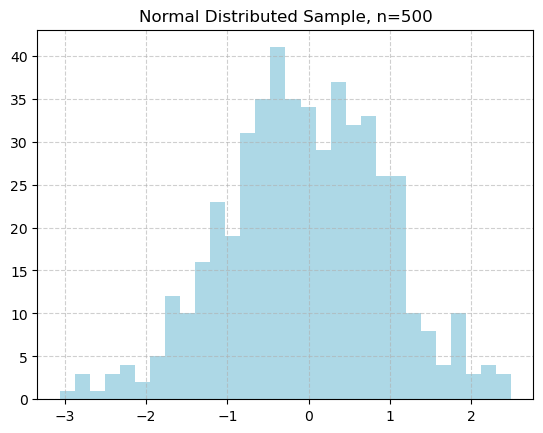

In [5]:
#Test mit Normalverteilung
#Normalverteilung hat in der Theorie einen Tail Index von 2
μ, σ, n = 0, 1, 500
normal_data_sample = np.random.normal(μ, σ, n)

plt.hist(normal_data_sample, bins=30, color = "lightblue")
plt.title("Normal Distributed Sample, n=" + str(n))
plt.grid(True, linestyle='--', alpha=0.6)

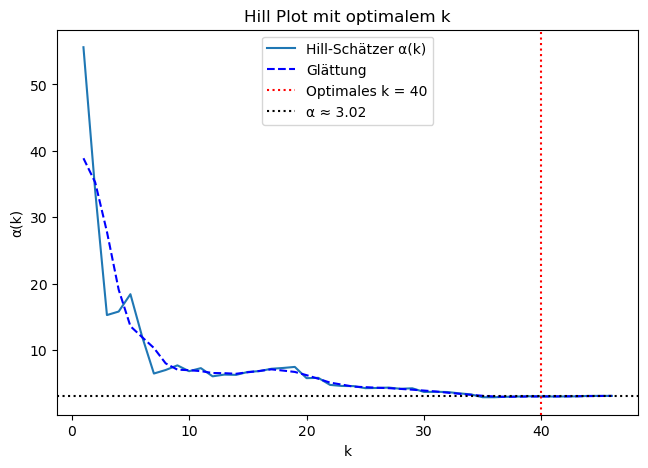

3.0221317630810813


In [6]:
#print(hill_α_CrossValidation(normal_data_sample))
print(hill_α_plot_estimator(normal_data_sample))

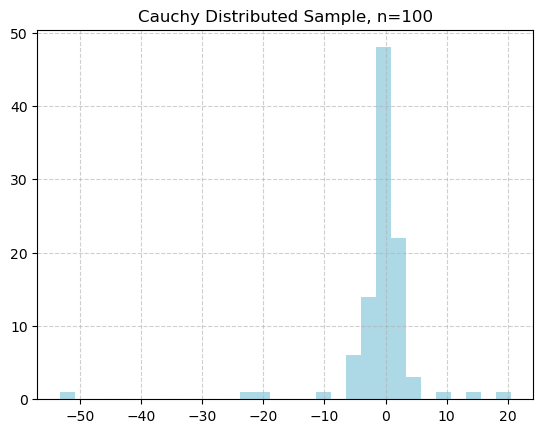

In [7]:
#Test mit Cauchy Verteilung
#Cauchy Verteilung hat in der Theorie einen Tail Index von 1
n = 100
cauchy_data_sample = np.random.standard_cauchy(n)

plt.hist(cauchy_data_sample, bins=30, color = "lightblue")
plt.title("Cauchy Distributed Sample, n=" + str(n))
plt.grid(True, linestyle='--', alpha=0.6)

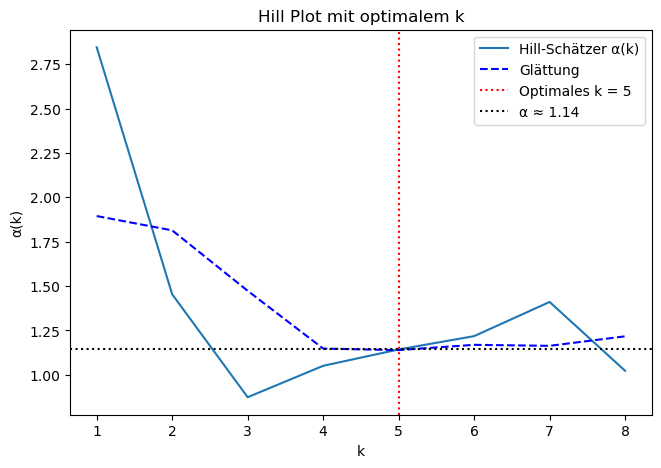

1.142530979584199


In [8]:
#print(hill_α_CrossValidation(cauchy_data_sample))
print(hill_α_plot_estimator(cauchy_data_sample))

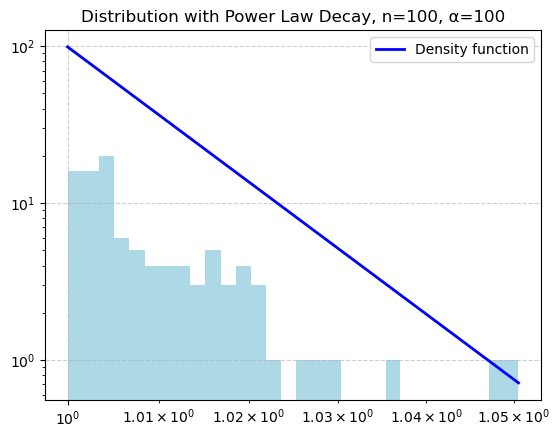

In [9]:
"""
Direkter Test beider Schätzer. 
Initialisierung von Zufallsvariablen mit ganz bestimmten Power Law Delays.
"""
x_min = 1
α = 100
u = np.random.uniform(0, 1, n)

sample_power_law_α = x_min * (1 - u) ** (-(1 / α))
plt.hist(sample_power_law_α, bins=30, color = "lightblue")
plt.title("Distribution with Power Law Decay, n=" + str(n) + ", α=" + str(α))
plt.grid(True, linestyle='--', alpha=0.6)

x = np.linspace(x_min, sample_power_law_α.max(), 1000)
f_power_law = (α - 1) / x_min * (x / x_min) ** (-α)

plt.plot(x, f_power_law, lw=2, label="Density function", color="blue")
plt.xscale("log")
plt.yscale("log")
plt.legend()

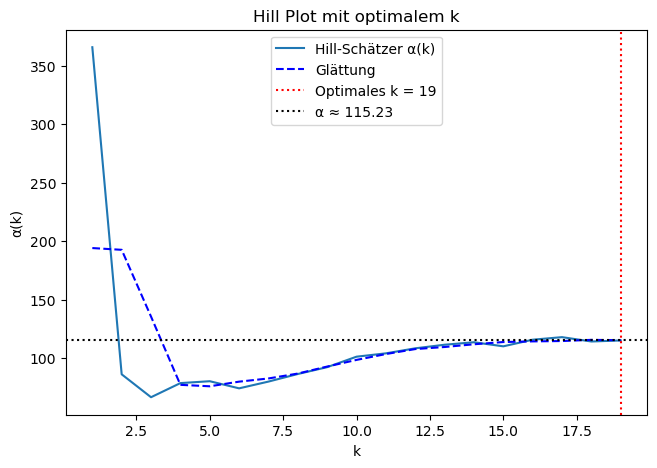

115.22674587452848
123.29421532545868


In [10]:
#print(hill_α_CrossValidation(sample_power_law_α))
print(hill_α_plot_estimator(sample_power_law_α))
print(hill_α_estimator_Bootstrap_mse(sample_power_law_α))

In [ ]:
def simulate_efficiency(alpha_true=2.0, size=1000, reps=1000, x_min = 1):
    estimates = []

    for _ in range(reps):
        # Pareto mit tail-index alpha_true
        sample_power_law_α = x_min * (1 - u) ** (-(1 / α))
        alpha_hat = hill_α_estimator_Bootstrap_mse(sample_power_law_α)
        estimates.append(alpha_hat)

    estimates = np.array(estimates)
    bias = np.mean(estimates) - alpha_true
    var = np.var(estimates)
    mse = bias**2 + var
    
    return {
        "Bias": bias,
        "Variance": var,
        "MSE": mse,
        "Mean estimate": np.mean(estimates),
    }

print(simulate_efficiency())

C:\Users\phhor\AppData\Local\Temp\ipykernel_4308\214459402.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return k / np.sum(np.log(top_k / x_k))
